In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')

In [3]:
len(data)

1460

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Разделяем данные на таргет и признаки

In [5]:
X=data.iloc[:, 0:80]
y=data.iloc[:, 80]

Обработка категориальных признаков

In [6]:
cat_feat = list(data.dtypes[data.dtypes == object].index)

In [7]:
X[cat_feat] = X[cat_feat].fillna('nan')
cat_feat_full = list(X.dtypes[X.dtypes == object].index)
cat_nunique = X[cat_feat_full].nunique()
cat_feat = list(cat_nunique[cat_nunique < 5].index)
dummy_X = pd.get_dummies(X[cat_feat], columns=cat_feat)
dummy_X.head()

,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,...,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan
0,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
1,0,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,1
2,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,0,1,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


Обработка вещественных признаков

In [8]:
num_feat = [f for f in X if f not in (cat_feat_full + ['Id'])]
scaler = StandardScaler()
scaler.fit(X[num_feat])
X_median = X[num_feat].median()
X[num_feat] = X[num_feat].fillna(X_median)
X[num_feat].head()

/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


Объединяем вещественные и категориальные признаки

In [9]:
X=pd.concat([X[num_feat], dummy_X], axis=1)
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_nan,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_nan
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,1,0,0,0,0,1,0,0,0,1
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,1
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,1,0,0,0,0,1,0,0,0,1
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,1,0,0,0,1,0,0,0,1
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,1,0,0,0,0,1,0,0,0,1


Создадим модель для случайного леса

In [10]:
rfc= RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)

Разделим данные на тестовую и обучающие выборки

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Проверим качество модели

In [15]:
StrKFold = model_selection.StratifiedKFold(n_splits=5, random_state=1234)

In [16]:
scoring = 'neg_mean_absolute_error'
results = model_selection.cross_val_score(rfc, X_test, y_test, cv=StrKFold, scoring=scoring)
print("MAE:", results.mean(), results.std())

/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


MAE: -35730.154448545545 9011.747985739456


Вывод важных признаков

In [17]:
importances=rfc.feature_importances_

In [18]:
index_importances=np.where(importances>0.03)

([<matplotlib.axis.YTick at 0x7f6e58245828>,
 <a list of 11 Text yticklabel objects>)

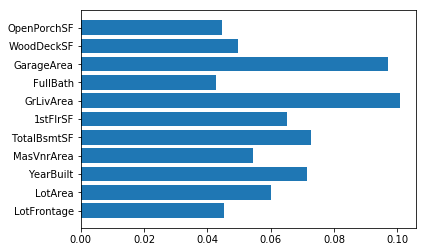

In [19]:
plt.barh(np.arange(len(importances[index_importances])), importances[index_importances])
plt.yticks(np.arange(len(X.columns[index_importances])),X.columns[index_importances])

Выберем модели

In [20]:
logr = LogisticRegression()
lr = LinearRegression()
rfc= RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)

Функци для мета признаков

In [21]:
def get_meta_features(model, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float) #массив из нулей для y_train
    meta_test = np.zeros_like(y_test, dtype=float) #массив из нулей для y_test
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)): #разделили выборку
        # для каждого разбиения выборки:
        model.fit(X_train.iloc[train_ind], y_train.iloc[train_ind]) #обучаем модель
        meta_train[test_ind] = model.predict(X_train.iloc[test_ind]) #фитим модель на маленькой тест. выборке
        meta_test += model.predict(X_test) #фитим модель на большой тестовой выборке
    
    return pd.DataFrame(meta_train), pd.DataFrame(meta_test) / stack_cv.n_splits 
    # возвращаются предсказанные значения для обучающей и тестовой выборки

Разделим выборку на 5 фолдов

In [22]:
stack_cv = StratifiedKFold(n_splits=5, random_state=555)

Создадим мета-признаки

In [23]:
meta_train_logr, meta_test_logr = get_meta_features(logr, X_train, y_train, X_test, stack_cv)

/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/benito/anaconda3/lib/python3.7/si

In [24]:
meta_train_lr, meta_test_lr = get_meta_features(lr, X_train, y_train, X_test, stack_cv)

/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [25]:
meta_train_rfc, meta_test_rfc = get_meta_features(rfc, X_train, y_train, X_test, stack_cv)

/home/benito/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Добавим мета-признаки в модель

In [26]:
X_train['logr_pred']=meta_train_logr
X_train['lr_pred']=meta_train_lr
X_train['rfc_pred']=meta_train_rfc

/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [27]:
X_test['logr_pred']=meta_test_logr
X_test['lr_pred']=meta_test_lr
X_test['rfc_pred']=meta_test_rfc

/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/benito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Используем регуляризованную лог регрессию в качестве алгоритма второго уровня

In [28]:
X_train=X_train.fillna(X_train.mean())
X_test=X_test.fillna(X_test.mean())

In [29]:
meta = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)

In [30]:
meta.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=0.5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
y_pred=meta.predict(X_test)

In [32]:
mean_absolute_error(y_test, y_pred)

34677.00342465754

MAE: -35730.154448545545 - это ошибка на модели без стекинга